In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
#%matplotlib widget
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from progressbar import ProgressBar
import torch
import torch.nn as nn
import torch.nn.functional as F
from img_utils import *

fg_path = './models/Batch Renderding/scene/image_out/*'
#label_path='./models/Batch Renderding/scene/label_out/*'
bg_path = '/run/media/d0048/DATA/data/imagenet/raw/val_nodir/*'

Loading forgrounds from ./models/Batch Renderding/renders/scene_horizontal_no_number/image_out/*:
[ 6228 13326     1     1]
[40917     1]
[ 6228 13326     1     1]
[37548     1     1]
[40278     1]
[28290     1]
[14140  3759]
[ 1696     1 32208     1     1]
[23824]
[ 9950 11870]
[11085 11152]
[ 4641     1 14934     1]
[22180     1     1]
[6910 9598]
[22367     1]
[ 7882 11272]
[33316     1     1]
[ 1038 26601]
[24241     1]
[16958]
[    1 23958     1     1]
[  465 19451]
[18403]
[14747  3737]
[34938     1]
[9505 8377]
[32026     1]
[39650     1     1     1]
[13747  3785]
[23999     1     1]
[23467     1]
[32757     1     1]
[ 1269 28662]
[ 3741 20993     1     1     1]
[18214]
[ 4976 21047     1]
[15844  8081]
[19813  3622]
[ 6977 14297]
[18409     1]
[30593  2345]
[30476]
[29226]
[24677]
[ 5219 20550     1     1]
[ 6851 13184     1]
[ 1312     1 20630]
[22061     1]
[31380     1]
[ 1302     1 30605     1     1]
[21349]
[ 8964 12041]
[13635  7469]
[20568  4436]
[22528]
[16991]
[23447]


/usr/local/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


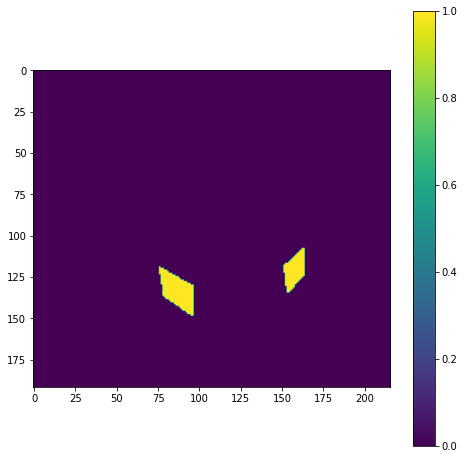

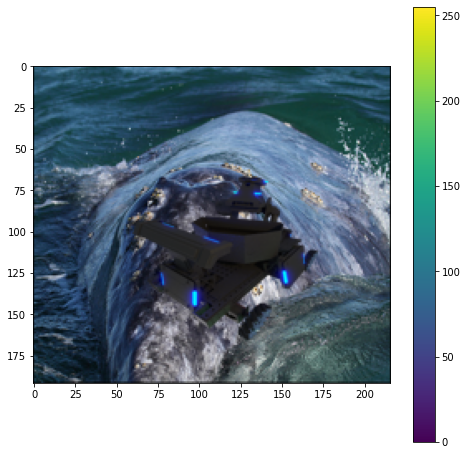

In [10]:
img, label = get_blended(plot=False, augment=False)
img = np.array(img)
label = np.array(label)
label = np.sum(label, axis=2, keepdims=True)
label[label != 0] = 1

plt.figure(figsize=(8,8))
plt.imshow(label.squeeze())
plt.colorbar()
plt.figure(figsize=(8,8))
plt.imshow(img.squeeze())
plt.colorbar()

## Augmentation

### Augmentor

In [ ]:
import Augmentor
p = Augmentor.Pipeline(fg_path.replace('*',''))
p.ground_truth(fg_path.replace('*','').replace('image','label'))
p.rotate(probability = 1, max_left_rotation =5, max_right_rotation =5)
p.flip_left_right(probability = 0.5)
p.flip_top_bottom(probability = 0.3)
p.sample(10)

In [ ]:
batch_size = 6
g = p.keras_generator(batch_size=batch_size)

X, y = next(g)
print(X.shape)
print(y.shape)

### ImgAug

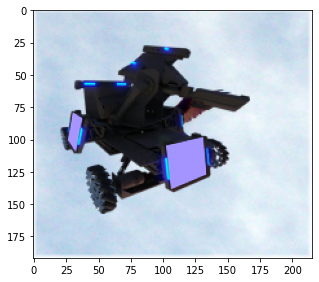

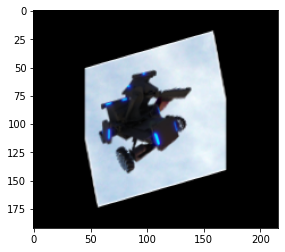

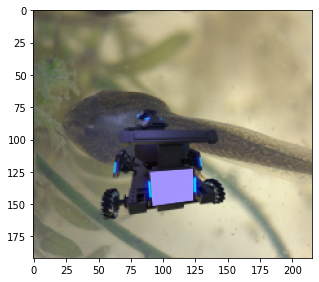

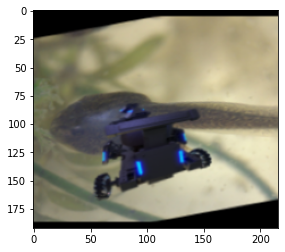

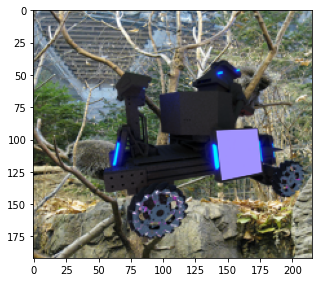

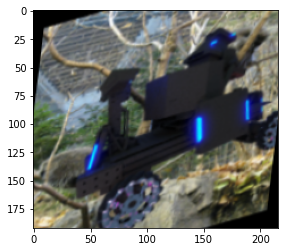

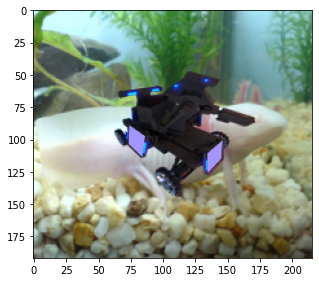

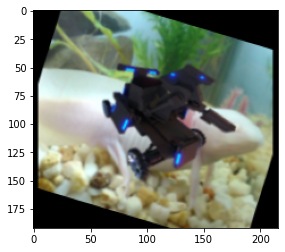

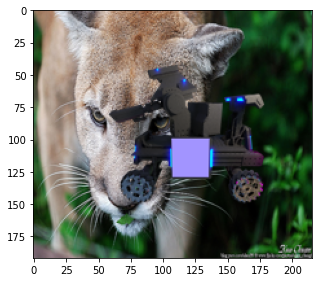

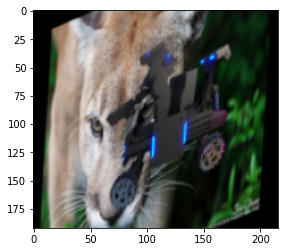

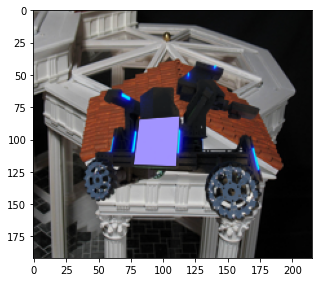

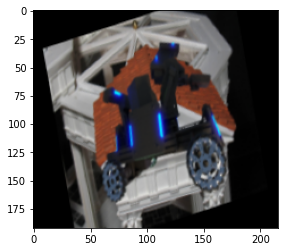

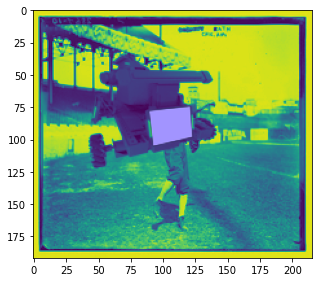

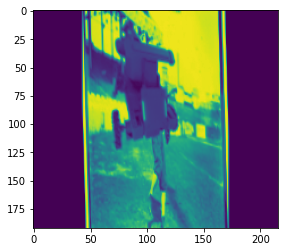

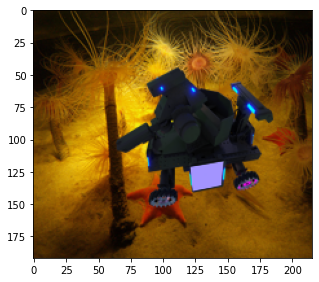

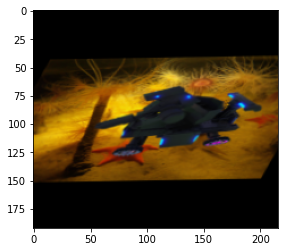

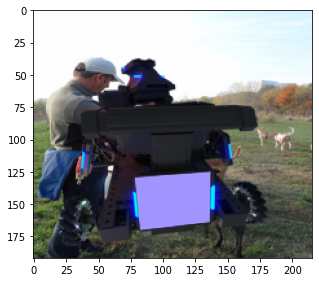

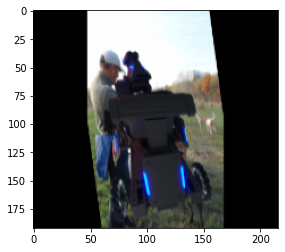

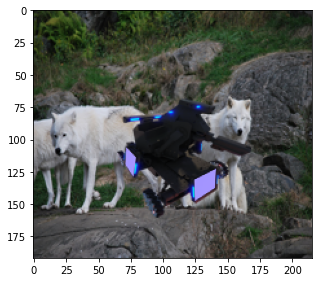

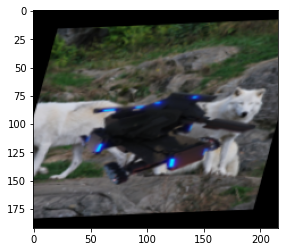

In [8]:
seq = iaa.Sequential(
    [
        iaa.ScaleX((0.5, 1.5)),
        iaa.ScaleY((0.5, 1.5)),
        iaa.ShearX((-20, 20)),
        iaa.ShearY((-20, 20)),
        ],
    random_order=True
)

def augment_pair(fg, label):
    label_i, segmaps_aug_i = seq(images=fg, segmentation_maps=label)
    return label_i, segmaps_aug_i

for i in range(10):
    img, label = get_blended(plot=True, augment=False)
    img = np.expand_dims(img, axis=0)  # [:,:,:,0:3]
    label = np.expand_dims(label, axis=0)
    img, label = augment_pair(img, label)
    plt.figure()
    plt.imshow(img.squeeze())
    #plt.imshow(label.squeeze())

### Samples

(16, 1, 192, 216)


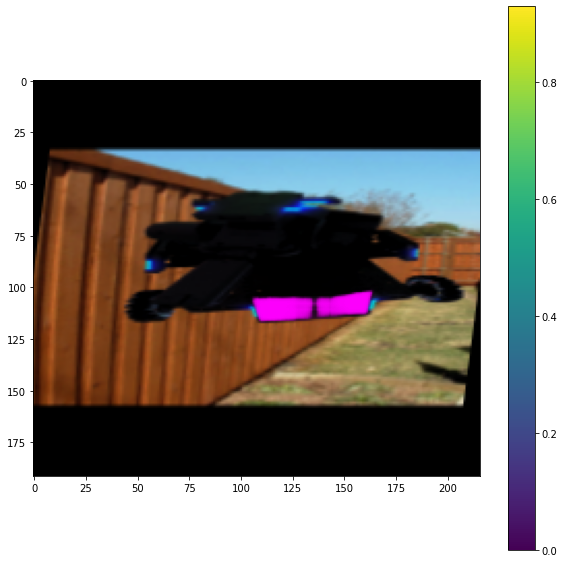

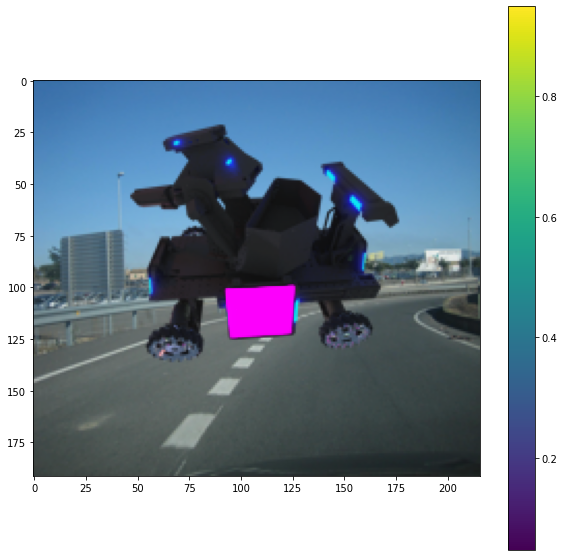

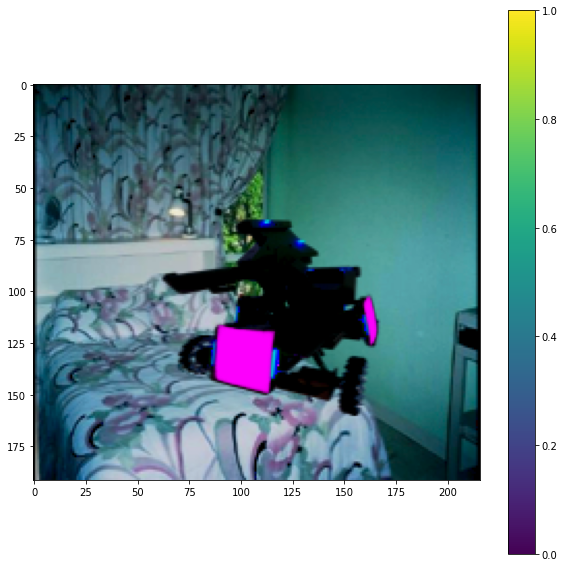

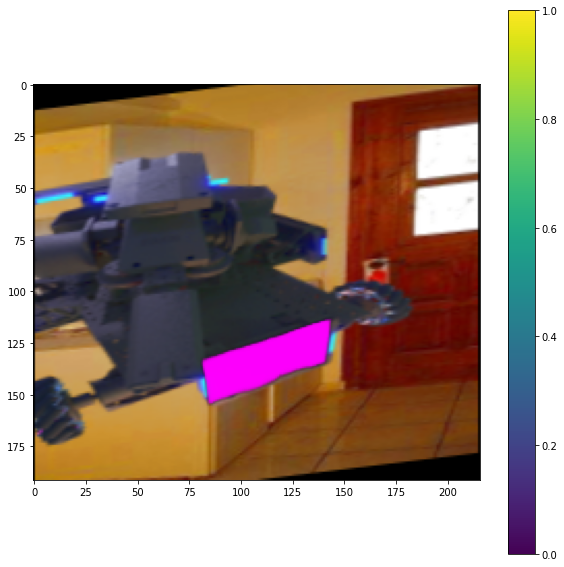

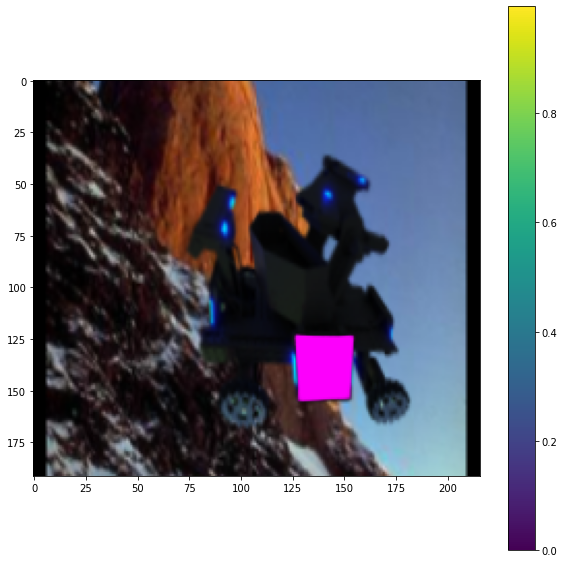

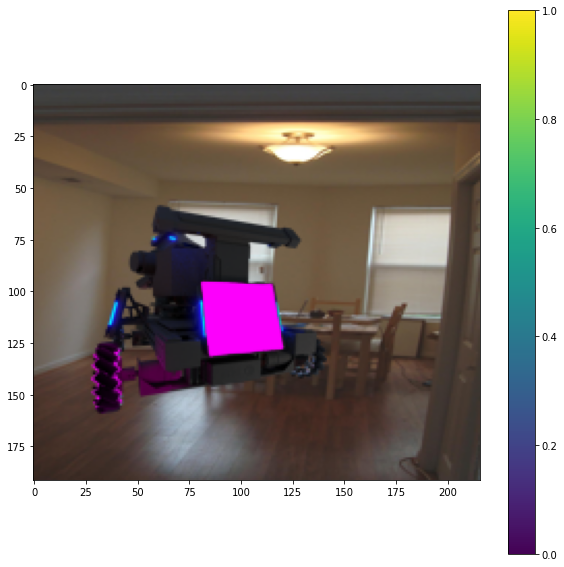

In [2]:
sample=np.load('./HAL/samples/sample.npz')['arr_0']
sample_img=np.load('./HAL/samples/sample_img.npz')['arr_0'].transpose([0,2,3,1])
#sample_label=np.load('./HAL/samples/sample_label.npz')['arr_0']
print(sample.shape)
#sample[sample<0.5]=0
for idx in range(6):
    #plt.figure(figsize=(10, 10))
    #plt.imshow(sample_img[idx])
    #plt.colorbar()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_img[idx])
    plt.colorbar()

    see = sample[idx].squeeze()
    mask = np.array([see,np.zeros_like(see),see,(see)]).transpose([1,2,0])
    plt.imshow(mask)


    #plt.figure(figsize=(10, 10))
    #plt.imshow(sample[idx].squeeze())
    #plt.colorbar()
    
    #plt.figure(figsize=(10, 10))
    #plt.imshow(sample_label[idx].squeeze())
    #plt.colorbar()

### Real-world

In [11]:
batch_size=1

from fcn import *
#np.random.seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available
device='cpu'
model=Model().to(device)
#model = nn.DataParallel(model).to(device)
print(device)

Using Naive FCN
cpu


Choosing from 14 files


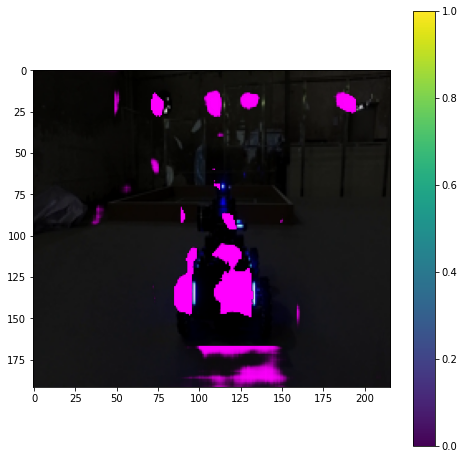

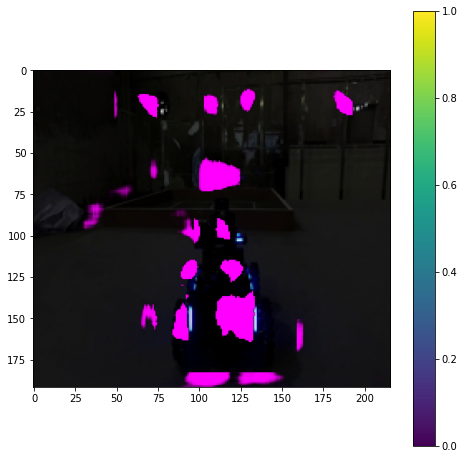

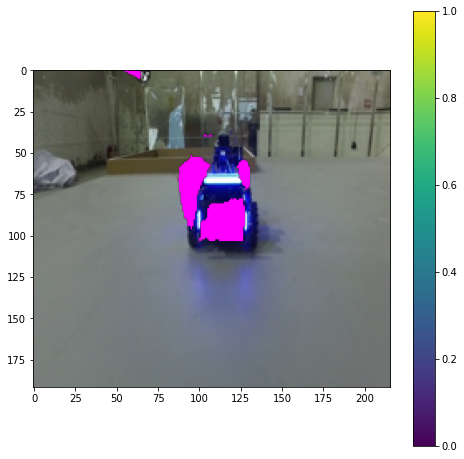

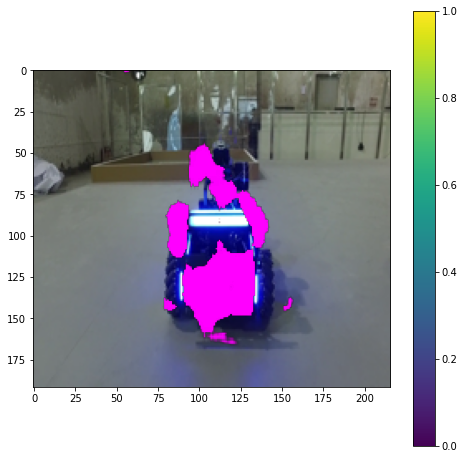

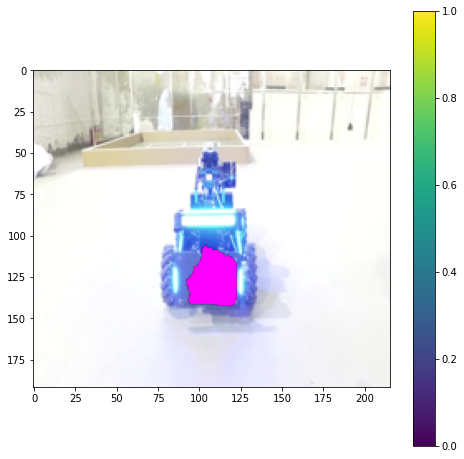

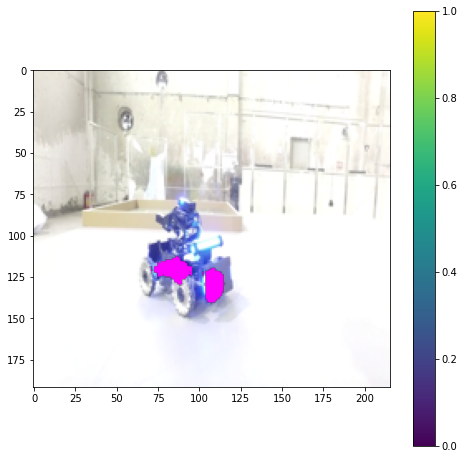

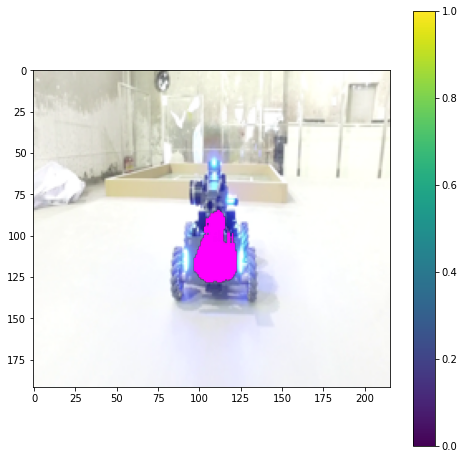

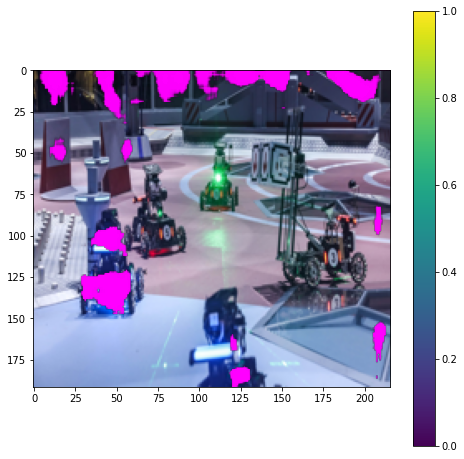

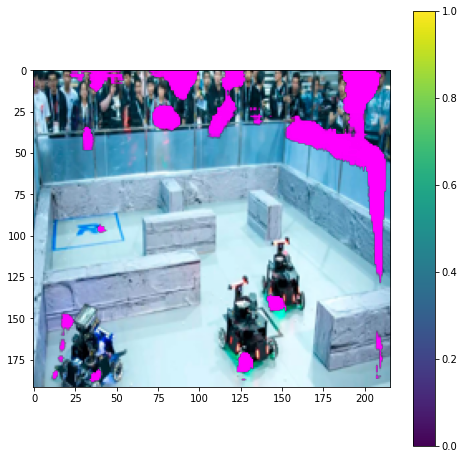

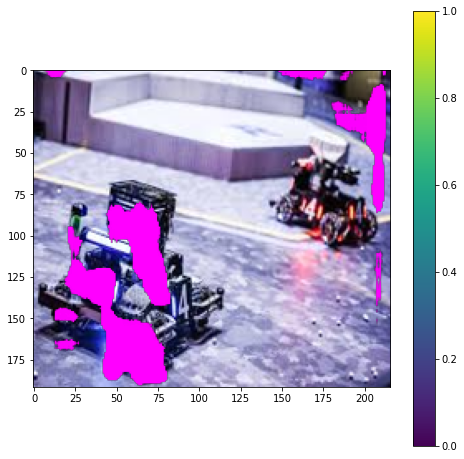

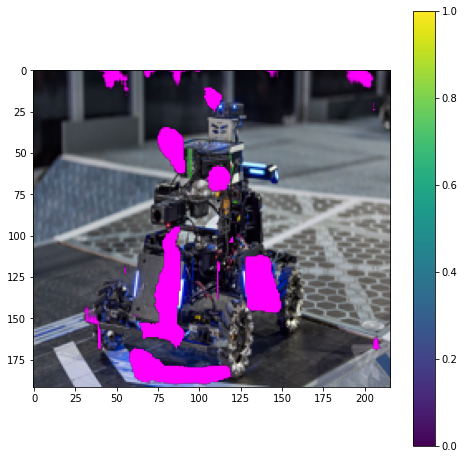

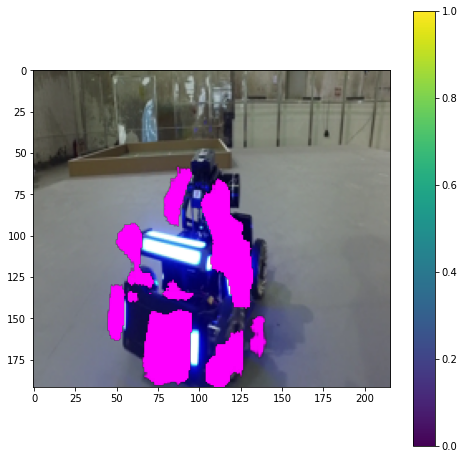

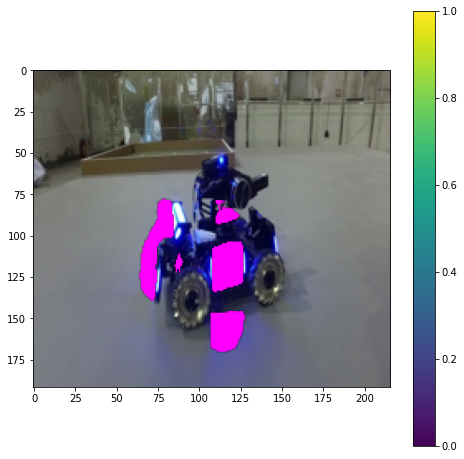

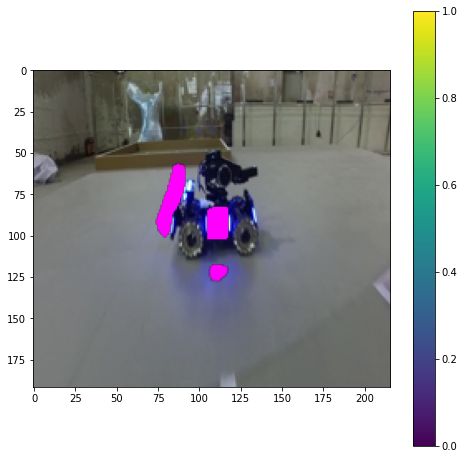

In [13]:
# original saved file with DataParallel
state_dict = torch.load('./checkpoint/model.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

def load_real_img(paths,plot=True):
    img_batch=[]
    for path in paths:
        bg = Image.open(path)
        bg = bg.resize(res)
        img=np.array(bg)[:,:,0:4]
        #img = img.reshape([1,res[1],res[0],-1])
        #img = seq(images=img).squeeze()
        #img[:, :, 0], img[:,:, 2] = img[:,:, 2], img[:, :,0].copy()

        img_batch.append(img.astype(np.float))
        if plot:
            plt.figure(figsize=[8,8])
            plt.imshow(img)
    img = torch.tensor(img_batch,dtype=torch.float,device=device).permute([0,3,1,2])
    return img

torch.cuda.empty_cache()
model.eval()

files=glob.glob('/home/d0048/Program-code/IlliniRobomaster/RMSynthesis/raw/blue/*')
print('Choosing from {} files'.format(files.__len__()))
for file in files:
    img=load_real_img([file])
    #print(img.shape)
    out=model(img)

    see=out.detach().cpu().numpy()
    #plt.figure(figsize=[8,8])
    #plt.imshow(see.squeeze())
    img = img.detach().cpu().numpy()
    
    see = see.squeeze()
    mask = np.array([see,np.zeros_like(see),see,(see)]).transpose([1,2,0])
    #print(mask.shape)
    plt.imshow(mask)
    plt.colorbar()